#### Imports

In [80]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
sns.set(style='white', context='notebook', palette='deep')
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

#### Data preparation

    1. Load data

In [64]:
train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')

In [65]:
train.sample()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
30481,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [66]:
Y_train = train['label']
X_train = train.drop(columns=['label'])

    2. Check for null and missing values

Check for images with missing values.

In [67]:
X_train.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

In [68]:
test.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

There are no missing values in the train and test dataset so we can go ahead.

    3. Normalization

In [69]:
X_train = X_train / 255
test = test / 255

    4. Reshape

Reshape image in 3 dimensions (height = 28px, width = 28px , canal = 1)

In [70]:
X_train = X_train.values.reshape(-1, 28, 28, 1)
test = test.values.reshape(-1, 28, 28, 1)

Tain and test images (28px x 28px) hve been stock into pandas dataframe as 1D vector of 784 values. We need to reshape the data to 28 x 28 x 1 3D matrices.

Keras requires an extra dimension in the end which correspond to channels. MNIST images are gray scaled so they use only one channel. For RGB images, there are 3 channels so we would have reshaped 784px to 28 x 28 x 3 3D matrices.

    5. Label encoding

Encode labels to one hot vectors (ex: 2 -> [0, 0, 1, 0, 0, 0, 0, 0, 0, 0])

In [71]:
Y_train.head()

0    1
1    0
2    1
3    4
4    0
Name: label, dtype: int64

In [72]:
from keras.utils import to_categorical
Y_train = to_categorical(Y_train, num_classes=10)

    6. Split training and validation set

In [76]:
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.1, random_state=2)

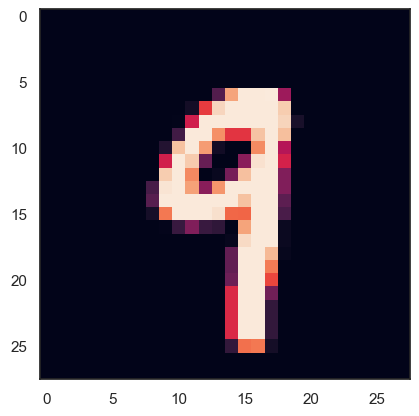

In [81]:
plt.imshow(X_train[2][:,:,0])

#### CNN Model

    1. Define the model

**model.add(Conv2D(...))** adds a convolutional layer to the model.
    
- La convolución es una operación fundamental en el procesamiento de imágenes que permite extraer características locales.

**filters=32** indica que la capa tendrá 32 filtros (también conocidos como kernels).

- Cada filtro aprenderá a detectar diferentes patrones en la entrada.

**kernel_size=(5,5)** expecifica el tamaño del kernel o filtro de convolución.

- En este caso, el kernel es una matriz 5x5 que se desplaza sobre la entrada para realizar la convolución.

**padding='Same'** controla cómo manejar el borde de la imagen.

- 'Same' significa que el borde se llena con ceros para mantener el tamaño de la entrada después de la convolución.

**activation='relu'** indica que se aplicará la función de activación ReLU (Rectified Linear Unit) después de realizar la convolución.

- ReLU es comúnmente utilizado para introducir no linealidades en la red.

**input_shape=(28,28,1)** especifica la forma de la entrada a la capa.

- En este caso, se espera que la entrada sea una imagen de 28x28 píxeles con un solo canal de color (escala de grises). El 1 en la última dimension indica que hay un solo canal.

**model.add(MaxPool2D(pool_size=(2,2)))**

- **MaxPool2D** es una capa de reducción de muestreo o pooling en una red neuronal convolucional.

- **pool_size=(2,2)** especifica el tamaño de la ventana sobre la cual se realizará el muestreo máximo. En este caso es una ventana de 2x2 píxeles.

- El propósito de esta capa es reducir el tamaño espacial de la representación para disminuir la cantidad de parámetros y cálculos en la red, preservando las características más importantes aprendidas por las capas de convolución.

- El muestreo máximo toma el valor máximo de cada ventana de la imagen y lo conserva, descartando el resto.

**model.add(Dropout(0.25))**

- **Dropout** es una técnica de regularización utilizada para reducir el sobreajuste (overfitting) en modelos de redes neuronales.

- **0.25** indica la fracción de unidades de la red que se desactivarán aleatoriamente durante el entrenamiento.

- Durante el entrenamiento, Dropout desactiva aleatoriamente una fracción de las neuronas de la capa anterior, lo que fuerza a la red a aprender características de manera más robusta, evitando que se especialice demasiado en ciertas características de los datos de entrenamiento.

- Esto ayuda a mejorar la generalización del modelo a nuevos datos y a reducir el riesgo de sobreajuste.

In [87]:
model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(5,5), padding='Same', activation='relu', input_shape=(28,28,1)))
model.add(Conv2D(filters=32, kernel_size=(5,5), padding='Same', activation='relu', input_shape=(28,28,1)))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(10, activation = "softmax"))

    2. Set optimizer and annealer

Once the layers added to the model, we need to set up a score function, a loss function and an optimisation algorithm.

We define the loss function to measure how poorly our model performs on images with known labels. It is the error rate between the observed labels and the predicted ones. We use a specific form for categorical classifications (>2 classes) called the "categorical_crossentropy".

The most important function is the optimizer. This function will iteratively improve parameters (filters kernel values, weights and bias of neurons ...) in order to minimise the loss.

I choosed RMSprop (with default values), it is a very effective optimizer. The RMSProp update adjusts the Adagrad method in a very simple way in an attempt to reduce its aggressive, monotonically decreasing learning rate. We could also have used Stochastic Gradient Descent ('sgd') optimizer, but it is slower than RMSprop.

The metric function "accuracy" is used is to evaluate the performance of our model. This metric function is similar to the loss function, except that the results from the metric evaluation are not used when training the model (only for evaluation).

In [89]:
from tensorflow.keras.optimizers import RMSprop

# Define the optimizer
optimizer = RMSprop(learning_rate=0.001, rho=0.9, epsilon=1e-08)

# Compile the model
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

more text

In [90]:
# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', patience=3, verbose=1, factor=0.5, min_lr=0.00001)

In [91]:
epochs = 30 # Turn epochs to 30 to get 0.9967 accuracy
batch_size = 86

    3. Data augmentation

text

In [93]:
history = model.fit(X_train, Y_train, batch_size = batch_size, epochs = epochs, validation_data = (X_val, Y_val), verbose = 1)

Epoch 1/30
440/440 [==============================] - 13s 29ms/step - loss: 0.0192 - accuracy: 0.9949 - val_loss: 0.0446 - val_accuracy: 0.9936
Epoch 2/30
440/440 [==============================] - 13s 30ms/step - loss: 0.0194 - accuracy: 0.9952 - val_loss: 0.0479 - val_accuracy: 0.9926
Epoch 3/30
440/440 [==============================] - 14s 31ms/step - loss: 0.0166 - accuracy: 0.9961 - val_loss: 0.0512 - val_accuracy: 0.9910
Epoch 4/30
440/440 [==============================] - 14s 31ms/step - loss: 0.0186 - accuracy: 0.9955 - val_loss: 0.0408 - val_accuracy: 0.9933
Epoch 5/30
440/440 [==============================] - 14s 32ms/step - loss: 0.0174 - accuracy: 0.9960 - val_loss: 0.0598 - val_accuracy: 0.9914
Epoch 6/30
440/440 [==============================] - 14s 32ms/step - loss: 0.0190 - accuracy: 0.9957 - val_loss: 0.0507 - val_accuracy: 0.9924
Epoch 7/30
440/440 [==============================] - 15s 33ms/step - loss: 0.0185 - accuracy: 0.9951 - val_loss: 0.0289 - val_accuracy:

In [94]:
datagen = ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    rotation_range=15,
    zoom_range=0.1,
    height_shift_range=0.1,
    width_shift_range=0.1,
    horizontal_flip=False,
    vertical_flip=False
)

datagen.fit(X_train)

In [95]:
history = model.fit_generator(datagen.flow(X_train, Y_train, batch_size=batch_size),
                              epochs=epochs, validation_data=(X_val, Y_val),
                              verbose=1, steps_per_epoch=X_train.shape[0] // batch_size,
                              callbacks=[learning_rate_reduction])

Epoch 1/30


C:\Users\noemi\AppData\Local\Temp\ipykernel_19864\2118646199.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(datagen.flow(X_train, Y_train, batch_size=batch_size),


439/439 [==============================] - 14s 31ms/step - loss: 0.1849 - accuracy: 0.9520 - val_loss: 0.0440 - val_accuracy: 0.9910 - lr: 0.0010
Epoch 2/30
439/439 [==============================] - 14s 32ms/step - loss: 0.1300 - accuracy: 0.9662 - val_loss: 0.0306 - val_accuracy: 0.9924 - lr: 0.0010
Epoch 3/30
439/439 [==============================] - 14s 33ms/step - loss: 0.1103 - accuracy: 0.9701 - val_loss: 0.0363 - val_accuracy: 0.9912 - lr: 0.0010
Epoch 4/30
439/439 [==============================] - 14s 32ms/step - loss: 0.1050 - accuracy: 0.9734 - val_loss: 0.0247 - val_accuracy: 0.9933 - lr: 0.0010
Epoch 5/30
439/439 [==============================] - 15s 33ms/step - loss: 0.0994 - accuracy: 0.9746 - val_loss: 0.0399 - val_accuracy: 0.9902 - lr: 0.0010
Epoch 6/30
439/439 [==============================] - 15s 34ms/step - loss: 0.0927 - accuracy: 0.9754 - val_loss: 0.0305 - val_accuracy: 0.9910 - lr: 0.0010
Epoch 7/30
439/439 [==============================] - 16s 36ms/step -